In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
from torch import nn
from sklearn.manifold import TSNE

from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_networkx, subgraph

torch.manual_seed(0)

c:\Users\natal\anaconda3\envs\deep_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


*Adapted from PyTorch geometric tutorials 2 and 3*

We will be using the packages PyTorch Geometric and networkx today. PyTorch Geometric (PyG) is the graph equivalent of PyTorch, and can be used in similar ways. Networkx is good for graph visualization. We'll learn how to practically work with and visualize graph data, and then try out two tasks: node classification and graph classification.

1. Working with graphs
2. Node classification 
3. Graph classificaition

# 1. Working with graphs

We'll see how we can load graph data using PyG and visulize it using networkx.

We'll start off by using the Cora dataset! Here, we have a citation graph: every node is a paper, and edges represent one citing the other. We want to predict which of the categories the papers fall into: Case Based, Genetic Algorithms, Neural Networks, Probabilistic Methods, Reinforcement Learning, Rule Learning, or Theory. Each node is described by a 1433-dimensional bag-of-words vector. ie) a vector in which 1 represents a word is included, and a 0 means it is not. 

Let's see what we're working with.

In [2]:
dataset = Planetoid(root='./data', name='Cora', transform=NormalizeFeatures(), split='full')

print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [3]:
graph = dataset[0]

print(f'Number of nodes: {graph.num_nodes}')
print(f'Number of node features: {graph.num_node_features}')
print(f'Number of edges: {graph.num_edges} \n')

print(f'Train percent: {graph.train_mask.sum() / graph.num_nodes * 100:.1f}%')
print(f'Validation percent: {graph.val_mask.sum() / graph.num_nodes * 100:.1f}%')
print(f'Test percent: {graph.test_mask.sum() / graph.num_nodes * 100:.1f}%')

Number of nodes: 2708
Number of node features: 1433
Number of edges: 10556 

Train percent: 44.6%
Validation percent: 18.5%
Test percent: 36.9%


What *is* our graph object?

In [4]:
print(graph)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


We see we have the following:
* **x**: Our feature matrix. Notice it is of size [nodes, features].
* **edge_index**: This is our list of the edge connections. Recall this is the more compact way of representing an adjacency matrix. It is of size [2, # of edges]
* **y**: Our node labels. We see it's of size [# of nodes].
* **train/val/test_mask**: These are binary masks that mask out the nodes for training validation and testing. Not every dataset has these built in, and in other cases you may want to split up your nodes using unctions from torch_geometric.utils such as RandomNodeSplit.

We can visualize this graph using networkx. Notice this is a large graph with many nodes, so we will take a subset of the graph to visualize.

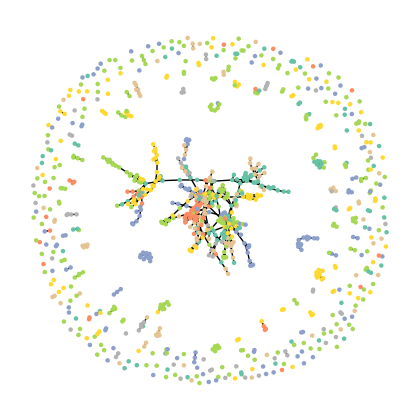

In [5]:
plt.figure(figsize=(4, 4))
networkx_graph = to_networkx(graph, to_undirected=True)
num_nodes = 1000

networkx_subgraph = networkx_graph.subgraph(np.arange(num_nodes))
nx.draw_spring(networkx_subgraph, node_size=5, node_color=graph.y[0:num_nodes], cmap="Set2")

# 2. Node classification

We're now going to use the labels of the training nodes to train a model. Note: the model has access to all the other nodes, just not their labels! This is referred to as the **transductive setting**. In transductive settings, we are working with data that all belongs to the same graph. We know about all the nodes that exist in the graph, and even have access to their features. However, we will only be exposed to the training labels during training. We will look at an **inductive** setting when we do graph classification: in that case, training and testing happen on separate graphs.

![](figures/transductive_inductive.png)

First, let's put together our model! We will be using the GCN layers we discussed last lecture.

In [6]:
class GCN(nn.Module):
    def __init__(self, input_feature_size=1433, hidden_feature_size=16, num_classes=7) -> None:
        super().__init__()
        self.conv1 = GCNConv(input_feature_size, hidden_feature_size)
        self.conv2 = GCNConv(hidden_feature_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)

        return x

To convince ourselves that it really IS useful to represent these nodes in a graph format, let's also have a basic FCNN as a comparison. For this model, we will not be using the edge information-- only the node features.

In [7]:
class FCNN(nn.Module):
    def __init__(self, input_feature_size=1433, hidden_feature_size=16, num_classes=7) -> None:
        super().__init__()
        self.linear1 = nn.Linear(input_feature_size, hidden_feature_size)
        self.linear2 = nn.Linear(hidden_feature_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)

        return x


Something cool we can do is look at the node embeddings we get from our untrained network vs. our trained network. Since our embeddings have 7 dimensions (for the 7 classes!), we will perform dimensionality reduction using TSNE to visualize them.

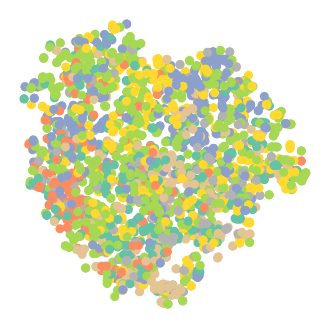

In [8]:
gnn_model = GCN()

initial_embedding = gnn_model(graph.x, graph.edge_index)
tsne_embedding = TSNE(n_components=2).fit_transform(initial_embedding.detach().numpy())

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=30, c=graph.y, cmap="Set2")
plt.show()

Now for the actual training steps. Since our graph is relatively small, we can feed in the entire graph at once. When working with very large graphs, more advanced batching techniques are required. We'll start by training the FCNN.

In [9]:
fcnn_model = FCNN()

criterion  = nn.CrossEntropyLoss()
optimizer_fcnn = torch.optim.Adam(fcnn_model.parameters(), lr=0.01)
train_losses = []
val_losses = []

for i in range(100):
    optimizer_fcnn.zero_grad()
    pred = fcnn_model(graph.x)
    train_loss = criterion(pred[graph.train_mask], graph.y[graph.train_mask])
    train_losses.append(train_loss.item())

    val_loss = criterion(pred[graph.val_mask], graph.y[graph.val_mask])
    val_losses.append(val_loss.item())

    train_loss.backward()
    optimizer_fcnn.step()

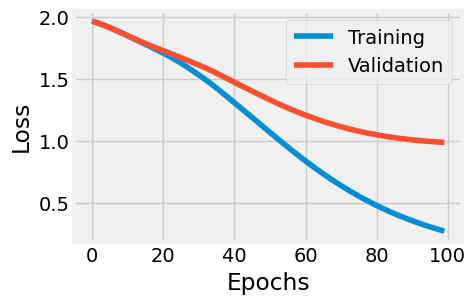

In [10]:
plt.figure(figsize=(5, 3))
plt.style.use('fivethirtyeight')
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [11]:
fcnn_model.eval()
with torch.no_grad():
    pred = fcnn_model(graph.x).argmax(dim=1)
    acc = (pred[graph.test_mask] == graph.y[graph.test_mask]).sum() / graph.test_mask.sum()
print(f'Accuracy: {acc.item() * 100:.2f}%')

Accuracy: 68.90%


Let's try GNN

In [12]:
gnn_model = GCN()

criterion  = nn.CrossEntropyLoss()
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
train_losses = []
val_losses = []

for i in range(100):
    optimizer_gnn.zero_grad()
    pred = gnn_model(graph.x, graph.edge_index)
    train_loss = criterion(pred[graph.train_mask], graph.y[graph.train_mask])
    train_losses.append(train_loss.item())

    val_loss = criterion(pred[graph.val_mask], graph.y[graph.val_mask])
    val_losses.append(val_loss.item())

    train_loss.backward()
    optimizer_gnn.step()

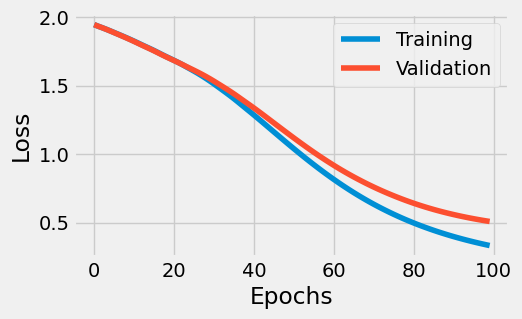

In [13]:
plt.figure(figsize=(5, 3))
plt.style.use('fivethirtyeight')
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [14]:
gnn_model.eval()
with torch.no_grad():
    pred = gnn_model(graph.x, graph.edge_index).argmax(dim=1)
    acc = (pred[graph.test_mask] == graph.y[graph.test_mask]).sum() / graph.test_mask.sum()
print(f'Accuracy: {acc.item() * 100:.2f}%')

Accuracy: 86.30%


The accuracy is much better when we use a GNN vs. an FCNN!

Let's have a look at the size of the learnt weights from the GNN.

In [15]:
for name, param in gnn_model.named_parameters():
    print(f'{name} has shape {param.data.shape}')

conv1.bias has shape torch.Size([16])
conv1.lin.weight has shape torch.Size([16, 1433])
conv2.bias has shape torch.Size([7])
conv2.lin.weight has shape torch.Size([7, 16])


As expected, we have weights of size [embedding size, features] and [classes, embedding size]. Notice there is no dependence on the number of nodes.

Let's have a look at our learnt embeddings to see if they're any different.

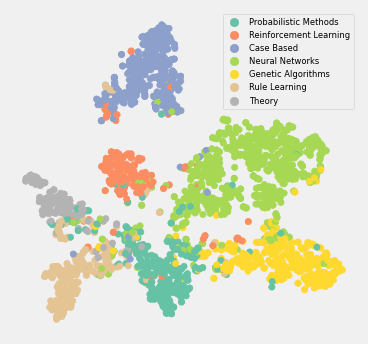

In [16]:
final_embedding = gnn_model(graph.x, graph.edge_index)
tsne_embedding = TSNE(n_components=2).fit_transform(final_embedding.detach().numpy())

# some silliness to get a properly ordered, color legend
classes = ['Case Based', 'Genetic Algorithms', 'Neural Networks', 'Probabilistic Methods', 'Reinforcement Learning', 'Rule Learning', 'Theory']
y_labels = [classes[i] for i in graph.y]
labels = list(dict.fromkeys(y_labels))

plt.figure(figsize=(4, 4))
plt.axis('off')
scatter = plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=20, c=graph.y, cmap="Set2")
plt.legend(handles=scatter.legend_elements()[0], labels=labels, fontsize=6)

# 3. Graph classification

We'll use the MUTAG dataset from TU Dortmund University-- it consists of multiple small graphs instead of one large one. Each graph represents a moleucle, and we want to predict whether it is mutageneic. The nodes are atoms with features that are one-hot encoded based off of what type of atom they are.

Note that this is now an **inductive** task. We train sets of weights that get applied to entirely new and unseen data. 

In [17]:
dataset = TUDataset(root='.data/', name='MUTAG')

print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Number of graphs: 188
Number of features: 7
Number of classes: 2


In [18]:
graph = dataset[0]

print(f'Number of nodes: {graph.num_nodes}')
print(f'Number of node features: {graph.num_node_features}')
print(f'Number of edges: {graph.num_edges} \n')

Number of nodes: 17
Number of node features: 7
Number of edges: 38 



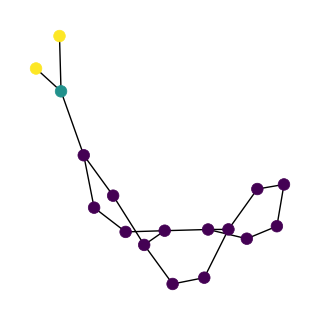

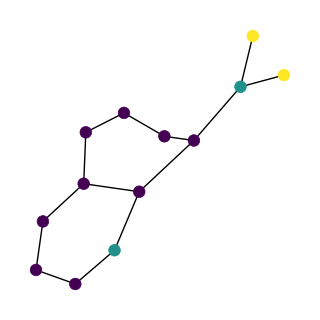

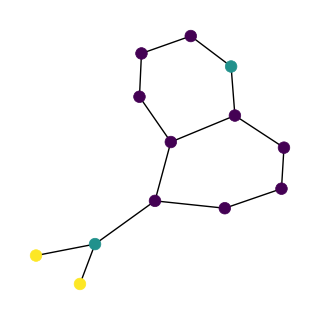

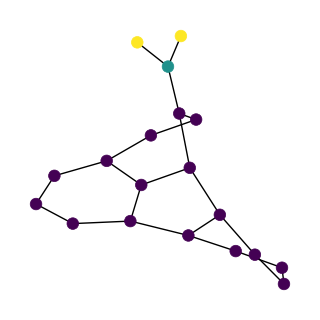

In [19]:
for i in range(4):
    graph = dataset[i]
    networkx_graph = to_networkx(graph, to_undirected=True)
    atom_categories = torch.argwhere(graph.x)[:, 1]
    plt.figure(figsize=(3, 3))
    nx.draw_spring(networkx_graph, node_size=70, node_color=atom_categories)
    

Since we are working with multiple small graphs, ideally we would batch them together for improved computational efficiency. Batching in the traditional sense (padding matrices and stacking along another dimension), is computationally expensive. So PyG does it as such: 

![](figures/gnn_batching.png)

In [20]:
dataset = dataset.shuffle()
num_graphs = len(dataset)

train_set = dataset[:int(0.6 * num_graphs)]
val_set = dataset[int(0.6 * num_graphs):int(0.8 * num_graphs)]
test_set = dataset[int(0.8 * num_graphs):]

train_loader, val_loader, test_loader = (
    DataLoader(train_set, batch_size=64),
    DataLoader(val_set, batch_size=64),
    DataLoader(test_set, batch_size=64),
)

We see we get a batch vector feature that tells us which graph each node in the batch is from.

In [21]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2548], x=[1150, 7], edge_attr=[2548, 4], y=[64], batch=[1150], ptr=[65])

Step 2:
Number of graphs in the current batch: 48
DataBatch(edge_index=[2, 1854], x=[842, 7], edge_attr=[1854, 4], y=[48], batch=[842], ptr=[49])



We'll put together a new GNN model for our graph classification task. It's similar to before, except we will have to change the head. To create a graph embedding from our node embeddings, we can take the average of our node embeddings. This sort of layer that converts node emebddings to graph embeddings is referred to as a 'readout' layer.

In [22]:
class GCN(nn.Module):
    def __init__(self, input_feature_size=7, hidden_feature_size=32, num_classes=2) -> None:
        super().__init__()
        self.conv1 = GCNConv(input_feature_size, hidden_feature_size)
        self.conv2 = GCNConv(hidden_feature_size, hidden_feature_size)
        self.lin = nn.Linear(hidden_feature_size, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        
        x = global_mean_pool(x, batch)  # output is of size [batch, hidden_features]
        x = self.lin(x)

        return x

Now, let's train

In [23]:
gnn_model = GCN()

criterion  = nn.CrossEntropyLoss()
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
train_losses = []
val_losses = []

for i in range(100):
    train_loss = 0
    for data in train_loader:
        optimizer_gnn.zero_grad()
        pred = gnn_model(data.x, data.edge_index, data.batch)
        loss = criterion(pred, data.y)
        train_loss += loss.item()
        
        loss.backward()
        optimizer_gnn.step()

    train_loss /= len(train_set)
    train_losses.append(train_loss)

    val_loss = 0
    for data in val_loader:
        pred = gnn_model(data.x, data.edge_index, data.batch)
        loss = criterion(pred, data.y)
        val_loss += loss.item()

    val_loss /= len(val_set)
    val_losses.append(val_loss)

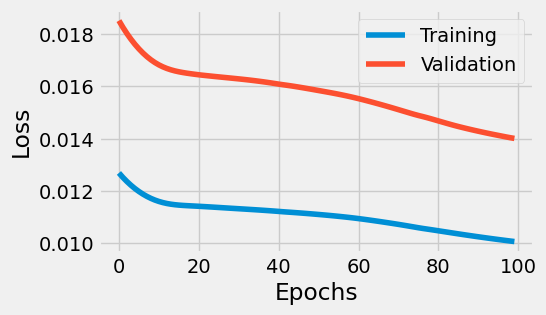

In [24]:
plt.figure(figsize=(5, 3))
plt.style.use('fivethirtyeight')
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [25]:
gnn_model.eval()
with torch.no_grad():
    correct = 0
    for data in test_loader:
        pred = gnn_model(data.x, data.edge_index, data.batch).argmax(dim=1)
        correct += (pred == data.y).sum()

acc = correct / len(test_set)
print(f'Accuracy: {acc.item() * 100:.2f}%')

Accuracy: 73.68%
